# MICCAI 2025 VLM3D Challenge: Data Exploration & Preprocessing

This notebook explores the CT-RATE dataset for the Vision-Language Modeling in 3D Medical Imaging (VLM3D) Challenge. We will:
- Load and inspect the reports, metadata, and labels splits from Hugging Face
- Visualize sample CT volumes (NIfTI)
- Analyze the distribution of report lengths and pathologies
- Implement basic preprocessing for both images and text


In [9]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import nibabel as nib
from pathlib import Path
from tqdm import tqdm


/Users/dawudizza/Desktop/vlm_miccai/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/dawudizza/Desktop/vlm_miccai/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load CT-RATE Dataset Splits

We will load the 'reports', 'metadata', and 'labels' splits from the CT-RATE dataset on Hugging Face using the `datasets` library.

In [10]:
# Load CT-RATE dataset splits from Hugging Face
reports_ds = load_dataset("ibrahimhamamci/CT-RATE", "reports")
metadata_ds = load_dataset("ibrahimhamamci/CT-RATE", "metadata")
labels_ds = load_dataset("ibrahimhamamci/CT-RATE", "labels")

print("Reports split loaded:", reports_ds)
print("Metadata split loaded:", metadata_ds)
print("Labels split loaded:", labels_ds)


Reports split loaded: DatasetDict({
    train: Dataset({
        features: ['VolumeName', 'ClinicalInformation_EN', 'Technique_EN', 'Findings_EN', 'Impressions_EN'],
        num_rows: 47149
    })
    validation: Dataset({
        features: ['VolumeName', 'ClinicalInformation_EN', 'Technique_EN', 'Findings_EN', 'Impressions_EN'],
        num_rows: 3039
    })
})
Metadata split loaded: DatasetDict({
    train: Dataset({
        features: ['VolumeName', 'Manufacturer', 'SeriesDescription', 'ManufacturerModelName', 'PatientSex', 'PatientAge', 'ReconstructionDiameter', 'DistanceSourceToDetector', 'DistanceSourceToPatient', 'GantryDetectorTilt', 'TableHeight', 'RotationDirection', 'ExposureTime', 'XRayTubeCurrent', 'Exposure', 'FilterType', 'GeneratorPower', 'FocalSpots', 'ConvolutionKernel', 'PatientPosition', 'RevolutionTime', 'SingleCollimationWidth', 'TotalCollimationWidth', 'TableSpeed', 'TableFeedPerRotation', 'SpiralPitchFactor', 'DataCollectionCenterPatient', 'ReconstructionTargetCe

## Inspect Dataset Structure and Sample Entries

Let's look at the structure and a few sample entries from each split to understand the data format.

In [12]:
# Inspect the structure and sample entries from each split
from pprint import pprint

print("Reports split structure:")
pprint(reports_ds)
print("\nSample report entry:")
pprint(reports_ds['train'][2])

print("\nMetadata split structure:")
pprint(metadata_ds)
print("\nSample metadata entry:")
pprint(metadata_ds['train'][0])

print("\nLabels split structure:")
pprint(labels_ds)
print("\nSample labels entry:")
pprint(labels_ds['train'][0])


Reports split structure:
{'train': Dataset({
    features: ['VolumeName', 'ClinicalInformation_EN', 'Technique_EN', 'Findings_EN', 'Impressions_EN'],
    num_rows: 47149
}),
 'validation': Dataset({
    features: ['VolumeName', 'ClinicalInformation_EN', 'Technique_EN', 'Findings_EN', 'Impressions_EN'],
    num_rows: 3039
})}

Sample report entry:
{'ClinicalInformation_EN': 'Not given.',
 'Findings_EN': 'Trachea and both main bronchi were in the midline and no '
                'obstructive pathology was observed in the lumen. In the '
                'non-contrast examination, the mediastinal could not be '
                'evaluated optimally. As far as can be seen; mediastinal main '
                'vascular structures, heart contour, size are normal. '
                'Pericardial effusion-thickening was not observed. Calcific '
                'atheroma plaque was observed in the descending aorta. '
                'Thoracic esophagus calibration was normal and no significant '
  

## Visualize Sample CT Volumes (NIfTI files)

Let's visualize a few slices from a sample CT volume using nibabel and matplotlib. Update the path to a local NIfTI file if needed.

Using sample: /Users/dawudizza/Desktop/vlm_miccai/data_volumes/dataset/train/train_2/train_2_a/train_2_a_2.nii.gz
Shape: (512, 512, 306)
Shape: (512, 512, 306)


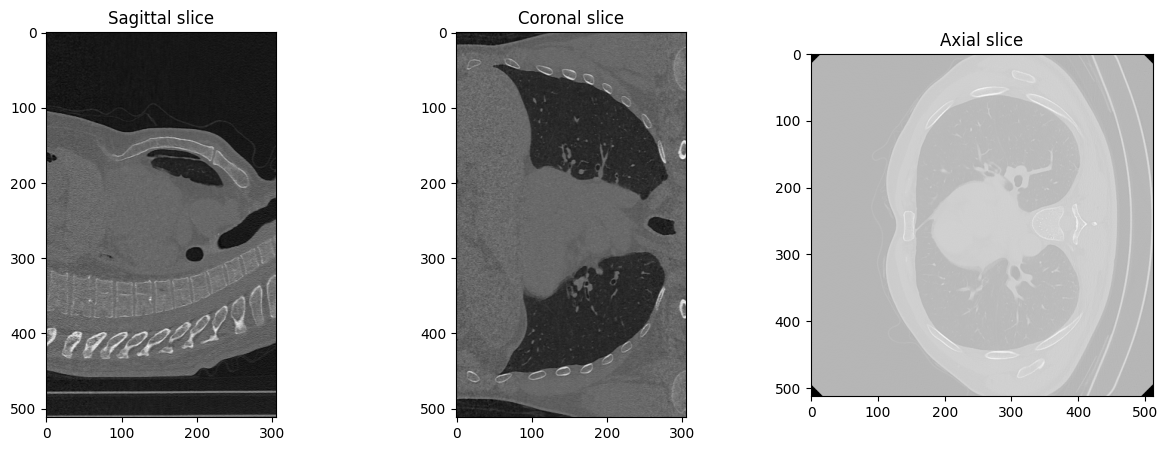

In [13]:
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt

# Visualize a specific CT volume using the provided absolute path
sample_nifti_path = Path("/Users/dawudizza/Desktop/vlm_miccai/data_volumes/dataset/train/train_2/train_2_a/train_2_a_2.nii.gz")

if sample_nifti_path.exists():
    print(f"Using sample: {sample_nifti_path}")
    img = nib.load(str(sample_nifti_path))
    data = img.get_fdata()
    print(f"Shape: {data.shape}")
    # Show three orthogonal slices
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(data[data.shape[0]//2, :, :], cmap='gray')
    axes[0].set_title('Sagittal slice')
    axes[1].imshow(data[:, data.shape[1]//2, :], cmap='gray')
    axes[1].set_title('Coronal slice')
    axes[2].imshow(data[:, :, data.shape[2]//2], cmap='gray')
    axes[2].set_title('Axial slice')
    plt.show()
else:
    print(f"Sample NIfTI file not found at {sample_nifti_path}. Please update the path.")


## Analyze Distribution of Report Lengths and Pathologies

Let's analyze the distribution of report lengths (in words) and the frequency of different pathologies in the dataset.

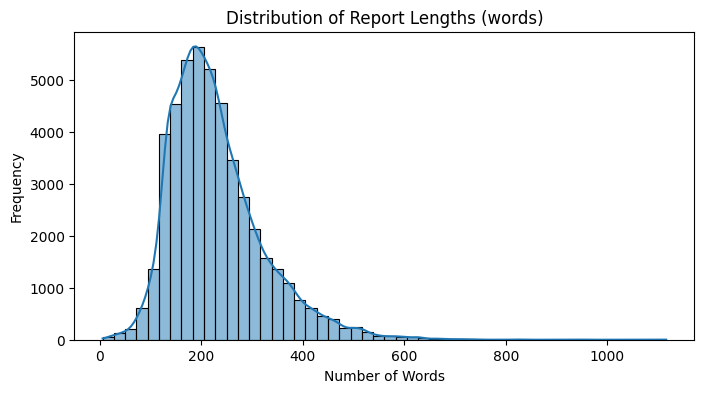

Pathology labels not found in labels split.


In [15]:
# Analyze report lengths using Findings_EN and Impressions_EN

def get_report_lengths(ds):
    return [
        len((str(item.get('Findings_EN', '')) + ' ' + str(item.get('Impressions_EN', ''))).split())
        for item in ds['train']
    ]

report_lengths = get_report_lengths(reports_ds)
plt.figure(figsize=(8, 4))
sns.histplot(report_lengths, bins=50, kde=True)
plt.title('Distribution of Report Lengths (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Analyze pathology label frequencies (example for binary labels)
if 'pathology_labels' in labels_ds['train'].features:
    pathology_labels = np.array(labels_ds['train']['pathology_labels'])
    label_sums = pathology_labels.sum(axis=0)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=np.arange(len(label_sums)), y=label_sums)
    plt.title('Pathology Label Frequencies')
    plt.xlabel('Pathology Index')
    plt.ylabel('Count')
    plt.show()
else:
    print('Pathology labels not found in labels split.')


## Basic Preprocessing for Images and Text

Let's implement basic preprocessing functions for CT volumes (e.g., normalization) and for text reports (e.g., lowercasing, removing extra whitespace).

In [18]:
# Basic preprocessing functions

def normalize_ct_volume(volume):
    """Normalize CT volume to zero mean and unit variance."""
    return (volume - np.mean(volume)) / np.std(volume)

def preprocess_report(findings, impressions):
    """Basic text preprocessing: lowercase and remove extra whitespace for findings and impressions."""
    text = f"{findings} {impressions}"
    return ' '.join(text.lower().split())

# Example usage:
clean_report = preprocess_report(reports_ds['train'][0]['Findings_EN'], reports_ds['train'][0]['Impressions_EN'])
